In [1]:
#Goal of this notebook is to create some simple code that can take a 1d array which we will suppose we have, i.e. it will be one of the inputs
#and we will take it and compare it to simulated data.

## Imports:

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from multiprocessing import Process, Queue
import time
import matplotlib.pyplot as plt

tfd = tfp.distributions

In [95]:
tf.tile([1./3,1./3,1./3], [2,])
tf.ones((2,3))*tf.constant([1./3,1./3,1./3])
amplitude = tf.constant([1., 2.])
tf.ones((3, tf.shape(amplitude)[0]))*amplitude 
pixels = tf.cast(tf.range(0, 100), dtype=tf.float32)
test = tfd.Normal(loc = [2., 5.], scale = [2., 0.5])
tf.transpose(amplitude*tf.ones((100, 2)))*tf.reshape(test.prob(tf.reshape(tf.ones(( 2, tf.shape(pixels)[0]))*pixels, (tf.shape(pixels)[0], 2))), (2,100))
# test.prob(tf.ones(( 2, tf.shape(pixels)[0]))*pixels)

<tf.Tensor: shape=(2, 100), dtype=float32, numpy=
array([[1.2098535e-01, 1.0104537e-14, 1.9947115e-01, 2.6766057e-04,
        1.2098535e-01, 7.9788458e-01, 2.6995480e-02, 2.6766057e-04,
        2.2159240e-03, 1.0104537e-14, 6.6915141e-05, 4.2927658e-32,
        7.4336003e-07, 0.0000000e+00, 3.0379428e-09, 0.0000000e+00,
        4.5673621e-12, 0.0000000e+00, 2.5261318e-15, 0.0000000e+00,
        5.1398796e-19, 0.0000000e+00, 3.8472939e-23, 0.0000000e+00,
        1.0594082e-27, 0.0000000e+00, 1.0731945e-32, 0.0000000e+00,
        3.9994241e-38, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00

15


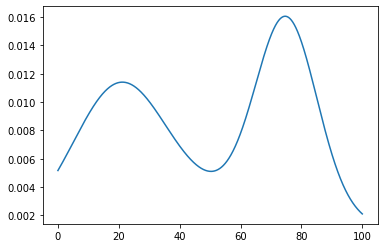

In [27]:
def main_gaussian(sigma_right, sigma_left, sigma_center, lambda_right, lambda_left, lambda_center):
  center_dist = tfd.Normal(loc = lambda_center, scale = sigma_center)
  print(sigma_right)
  try:
    print(sigma_right.shape)
  except:
    pass
  left_dist = tfd.Normal(loc = lambda_left, scale = sigma_left)
  right_dist = tfd.Normal(loc = lambda_right, scale = sigma_right)
  try:
    return tfd.Mixture(cat=tfd.Categorical(probs=tf.ones((tf.shape(sigma_right)[0],3))*tf.constant([1./3,1./3,1./3])),
  components=[
    center_dist,
    left_dist,
    right_dist
  ])
  except:
    return tfd.Mixture(cat=tfd.Categorical(probs=[1./3,1./3,1./3]),
  components=[
    center_dist,
    left_dist,
    right_dist
  ])

#test:
N = 100.
x = tf.linspace(0., N*1, int(1e4))
plt.plot(x, main_gaussian(15,10,40, 20, 75,50).prob(x));


In [96]:
#first try of function:
#we assume as explained on my onenote doc, a 3 piece gaussian.



# def od_sim_left_1d(pixel, ):
def joint_dist_gen(amplitude, sigmas, sigma_right, sigma_left, sigma_center, lambda_right, lambda_left, lambda_center, N):
  #we assume that each pixel is going to follow a normal distribution with the average given (lambda_i) given by what OD we expect from the "parrent" gaussians.
  mix = main_gaussian(sigma_right, sigma_left, sigma_center, lambda_right, lambda_left, lambda_center)
  pixels = tf.range(0, limit=N, delta=1.)
  try:
    amp = tf.transpose(tf.ones((tf.shape(pixels)[0], tf.shape(amplitude)[0]))*amplitude)
    # amp = amplitude
    pixels = pixels*tf.ones((mix.batch_shape[0], tf.shape(pixels)[0]))
    probs = tf.reshape(mix.prob(tf.reshape(pixels, (N, mix.batch_shape[0]))), (mix.batch_shape[0], N))
    print("pixels shape ", pixels.shape)
    #print("amp ", amp)
  except:
    amp = amplitude
    probs = mix.prob(pixels)
    print("test")
  print("mix shape", mix.batch_shape)
    
  print("prob shape", probs.shape)
  print(amp.shape)
  density = probs*amp #N sized tensor with the OD density of each pixel.
  #simulated distribution:
  #assume a poissonian dist for the # of counts:
  #tfd.Poisson(rate=density)
  #assume a normal distribution:
  return tfd.Normal(loc = density, scale=sigmas)

def closed_joint_dist_gen(N):
  #second = lambda r0, gamma, delta, I0, R0, care: self.joint_dist_gen_tr(r0, gamma, I0, R0, care, delta)
  first = [# x_tail
    tfd.Uniform(low=0., high=1.*N),
    #lambda_center
    lambda x: tfd.Uniform(low=N/2.-x, high=N/2.+x),
    #lambda_left
    lambda lambda_center, x: tfd.Uniform(low=0., high=N/2.-x),
    #lambda_right:
    lambda lambda_left, lambda_center, x: tfd.Uniform(low = N/2.+x, high=N),
    #sigma_center
    tfd.Uniform(low = 0., high = 1.),
    #sigma_left
    tfd.Uniform(low = 0., high = 1.),
    #sigma_right
    tfd.Uniform(low = 0., high = 1.),
    #production of the N scales of the N pixels:
    tfd.Uniform(low = 0.*tf.ones((N,)), high = 1.*tf.ones((N,))),
    #amplitude
    tfd.Normal(loc=1., scale=0.5)
    ]
    
  
  return tfd.JointDistributionSequential(first+[
    # likelihood
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted
    lambda amplitude , sigmas, sigma_right, sigma_left, sigma_center, lambda_right, lambda_left, lambda_center: #tfd.Independent(
    tfd.Independent(
        joint_dist_gen(amplitude, sigmas, sigma_right, sigma_left, sigma_center, lambda_right, lambda_left, lambda_center, N),#) #,
        reinterpreted_batch_ndims=1)
    #), reinterpreted_batch_ndims=1)
    ,
    #lambda _, care, R0, I0, delta, gamma, r0: tfd.Poisson(rate=np.float32(care*self.Z))
    ])
dist = closed_joint_dist_gen(100)
dist.resolve_graph()

tf.Tensor(0.1414243, shape=(), dtype=float32)
()
test
mix shape ()
prob shape (100,)
()


(('x', ()),
 ('lambda_center', ('x',)),
 ('lambda_left', ('lambda_center', 'x')),
 ('lambda_right', ('lambda_left', 'lambda_center', 'x')),
 ('sigma_center', ()),
 ('sigma_left', ()),
 ('sigma_right', ()),
 ('sigmas', ()),
 ('amplitude', ()),
 ('x1',
  ('amplitude',
   'sigmas',
   'sigma_right',
   'sigma_left',
   'sigma_center',
   'lambda_right',
   'lambda_left',
   'lambda_center')))

In [97]:
#sample the joint distribution:
dist.sample(2)

tf.Tensor([0.04435349 0.26440442], shape=(2,), dtype=float32)
(2,)
pixels shape  (2, 100)
mix shape (2,)
prob shape (2, 100)
(2, 100)


[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.9274592, 84.560684 ], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 48.577038, -26.536348], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 25.852596, -31.738688], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 64.8296 , 109.79625], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.88856924, 0.21886599], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.13480496, 0.09150732], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.04435349, 0.26440442], dtype=float32)>,
 <tf.Tensor: shape=(2, 100), dtype=float32, numpy=
 array([[3.4419167e-01, 1.5079856e-01, 3.6391032e-01, 2.0232475e-01,
         8.2792878e-01, 9.1271853e-01, 9.8663688e-02, 1.9067883e-01,
         9.1865325e-01, 9.4343817e-01, 2.3114717e-01, 6.5549517e-01,
         1.8891549e-01, 4.7348917e-01, 1.0105467e-01, 3.4757733e-01,
         4